This Notebook will focus on solving the 1D Euler classical equations for the Sod shock tube problem. The system of partial differential equations is written as follows:

$$
(1)\:\:\frac{\partial\rho}{\partial t}+\frac{\partial j}{\partial x}=0,
$$

$$
(2)\:\:\frac{\partial j}{\partial t}+\frac{\partial\left(p+\frac{1}{\rho}j^{2}\right)}{\partial x}=0,
$$

$$
(3)\:\:\frac{\partial e}{\partial t}+\frac{\partial\left[\frac{1}{\rho}j\left(e+p\right)\right]}{\partial x}=0,
$$

where $\rho$ is the density of the fluid, $p$ is the pressure, $j=\rho u$ the density momentum and $e$ the total energy density (total energy per unit volume). Therefore, our set of variables will be $\textbf{U}=(\rho,j,e)$. Moreover, the equation of state that relates the pressure and the rest of variables is:

$$
(4)\:\:p=(\gamma-1)\left(e-\frac{1}{2}\frac{j^{2}}{\rho}\right),
$$

where $\gamma=1.4$ is the heat capacity ratio. The space-time domain for the system to be computed will be:

$$
t\in[0,0.2]\:\:\:\text{and}\:\:\:x\in[0,1].
$$

The initial conditions for the Sod tube problem are:

$$ \text{Initial conditions ($t=0$)}=  \left\{
\begin{array}{ll}
      \rho_{0}:\:\rho=1.0 & \text{if $x\leq 0.5$ and $\rho=0.125$ else}\
      u_{0}:\:u=0 & \forall x\\
      j_{0}:\:j=0 & \forall x\\
      p_{0}:\:p=1.0 & \text{if $x\leq 0.5$ and $p=0.1$ else}\\
      e_{0}:\:e=\frac{1}{\gamma-1} & \text{if $x\leq 0.5$ and $e=\frac{0.1}{\gamma-1}$ else} \\
\end{array} 
\right. $$

Regarding the boundary conditions, this problem will be build up using Dirichlet boundary conditions, that is, for the conserved quantities ($\rho$, $j$ and $e$) the values on the spatial boundary will be constant and equal to the initial conditions.

$$
\rho(t,0)=1.0,\:\:\rho(t,1)=0.125
$$

$$
u(t,0)=u(t,1)=0
$$

$$
j(t,0)=j(t,1)=0
$$

$$
p(t,0)=1.0,\:\:p(t,1)=0.1
$$

$$
e(t,0)=\frac{1}{\gamma-1},\:\:e(t,1)=\frac{0.1}{\gamma-1}
$$

We will consider $nx=8192$ points for the grid in $x$, and a step in time of $\Delta t=0.00005$, that is, $nt=4000$.

In [1]:
import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

In [2]:
from __future__ import absolute_import
from clawpack import riemann
from clawpack.riemann.euler_with_efix_1D_constants import density, momentum, energy, num_eqn
from clawpack import pyclaw
import matplotlib.pyplot as plt

gamma = 1.4 # Ratio of specific heats

solver_type='classic'
kernel_language='Python'


if kernel_language =='Python':
    rs = riemann.euler_1D_py.euler_hllc_1D
elif kernel_language =='Fortran':
    rs = riemann.euler_hlle_1D

if solver_type=='sharpclaw':
    solver = pyclaw.SharpClawSolver1D(rs)
elif solver_type=='classic':
    solver = pyclaw.ClawSolver1D(rs)

solver.kernel_language = kernel_language

solver.bc_lower[0]=pyclaw.BC.extrap
solver.bc_upper[0]=pyclaw.BC.extrap

mx = 8192
x = pyclaw.Dimension(0.,1.0,mx,name='x')
domain = pyclaw.Domain([x])
state = pyclaw.State(domain,num_eqn)

state.problem_data['gamma'] = gamma
state.problem_data['gamma1'] = gamma - 1.

x = state.grid.x.centers

rho_l = 1.; rho_r = 1./8
p_l = 1.; p_r = 0.1
state.q[density ,:] = (x<0.5)*rho_l + (x>=0.5)*rho_r
state.q[momentum,:] = 0.
velocity = state.q[momentum,:]/state.q[density,:]
pressure = (x<0.5)*p_l + (x>=0.5)*p_r
state.q[energy  ,:] = pressure/(gamma - 1.) + 0.5 * state.q[density,:] * velocity**2


claw = pyclaw.Controller()
claw.tfinal = 0.2
claw.solution = pyclaw.Solution(state,domain)
claw.solver = solver
claw.num_output_times = 4000
claw.output_format = None
claw.keep_copy = True

status = claw.run()

2022-03-03 16:50:31,458 INFO CLAW: Solution 0 computed for time t=0.000000
2022-03-03 16:50:31,467 INFO CLAW: Solution 1 computed for time t=0.000050
2022-03-03 16:50:31,477 INFO CLAW: Solution 2 computed for time t=0.000100
2022-03-03 16:50:31,486 INFO CLAW: Solution 3 computed for time t=0.000150
2022-03-03 16:50:31,495 INFO CLAW: Solution 4 computed for time t=0.000200
2022-03-03 16:50:31,504 INFO CLAW: Solution 5 computed for time t=0.000250
2022-03-03 16:50:31,513 INFO CLAW: Solution 6 computed for time t=0.000300
2022-03-03 16:50:31,522 INFO CLAW: Solution 7 computed for time t=0.000350
2022-03-03 16:50:31,531 INFO CLAW: Solution 8 computed for time t=0.000400
2022-03-03 16:50:31,540 INFO CLAW: Solution 9 computed for time t=0.000450
2022-03-03 16:50:31,549 INFO CLAW: Solution 10 computed for time t=0.000500
2022-03-03 16:50:31,559 INFO CLAW: Solution 11 computed for time t=0.000550
2022-03-03 16:50:31,568 INFO CLAW: Solution 12 computed for time t=0.000600
2022-03-03 16:50:31,58

In [3]:
# Solution for t = 0.2

frame = claw.frames[len(claw.frames)-1]
print(frame.q.shape)
rho = frame.q[0,:]
j = frame.q[1,:]
e = frame.q[2,:]

(3, 8192)


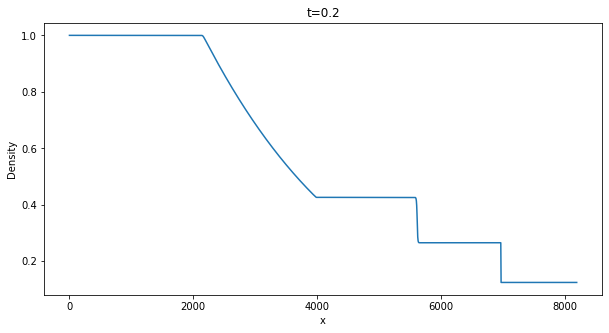

In [13]:
plt.plot(rho)
plt.rcParams["figure.figsize"] = (10,5)
plt.xlabel("x")
plt.ylabel("Density")
plt.title("t=0.2")
plt.savefig("Density_t_0_2.png")
plt.show()

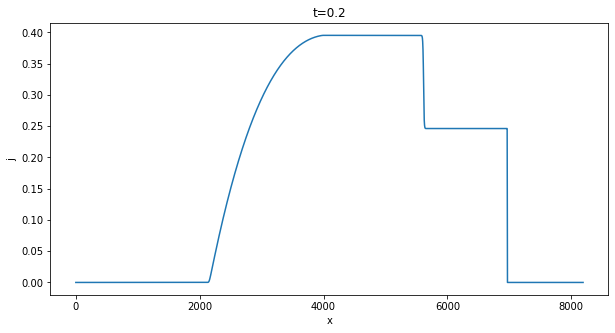

In [5]:
plt.plot(j)
plt.rcParams["figure.figsize"] = (10,5)
plt.xlabel("x")
plt.ylabel("j")
plt.title("t=0.2")
plt.savefig("j_t_0_2.png")
plt.show()

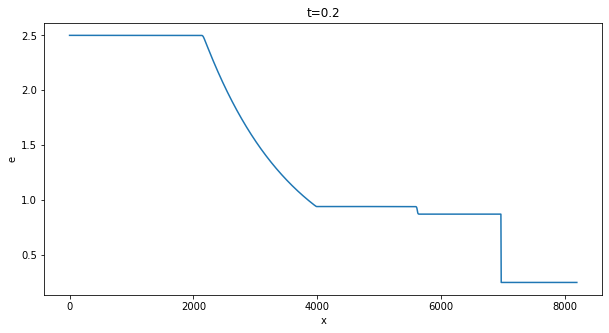

In [6]:
plt.plot(e)
plt.rcParams["figure.figsize"] = (10,5)
plt.xlabel("x")
plt.ylabel("e")
plt.title("t=0.2")
plt.savefig("e_t_0_2.png")
plt.show()

In [7]:
# Let's get the solution for all times for the 3 variables and export it.
import numpy as np

frames = claw.frames

times = np.linspace(0, 0.2, 4001)

rho_evolved = []
j_evolved = []
e_evolved = []

for frame in frames:
    rho_evolved.append(frame.q[0,:])
    j_evolved.append(frame.q[1,:])
    e_evolved.append(frame.q[2,:])

rho_evolved = np.array(rho_evolved) # Shape (nt, nx)
j_evolved = np.array(j_evolved) # Shape (nt, nx)
e_evolved = np.array(e_evolved) # Shape (nt, nx)

In [8]:
# Let's try to make some 3D plots...
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(0, 1, 8192)

X, T = np.meshgrid(x, times)

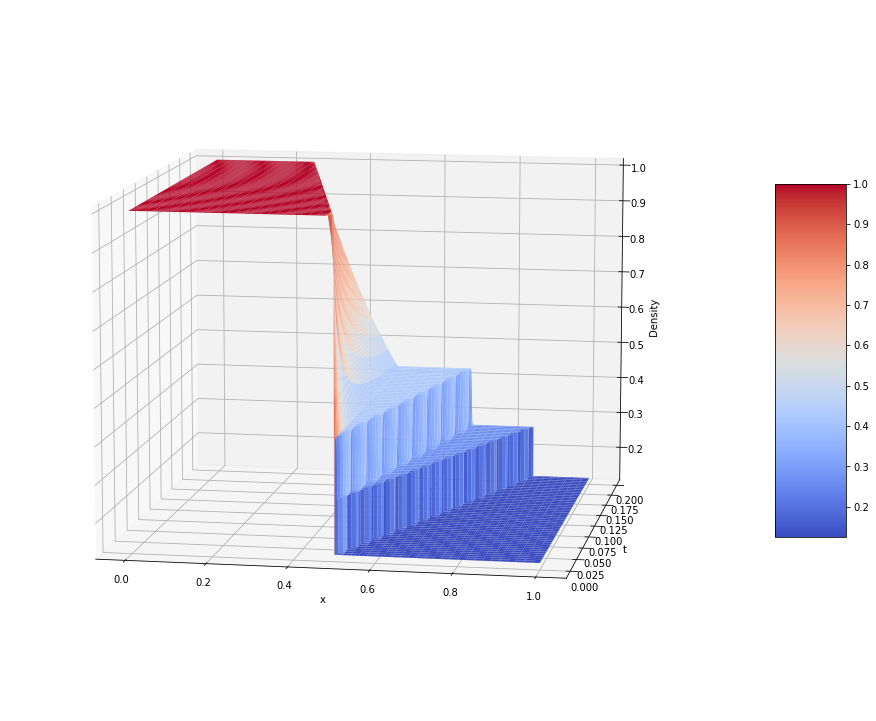

In [9]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.set_size_inches(22, 13)
surf = ax.plot_surface(X, T, rho_evolved, cmap = cm.coolwarm, linewidth = 0, antialiased = True)
ax.view_init(elev = 10, azim = 280)
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("Density")
fig.colorbar(surf, shrink = 0.5, aspect = 5)
plt.savefig("Density_3D.png")
plt.show()

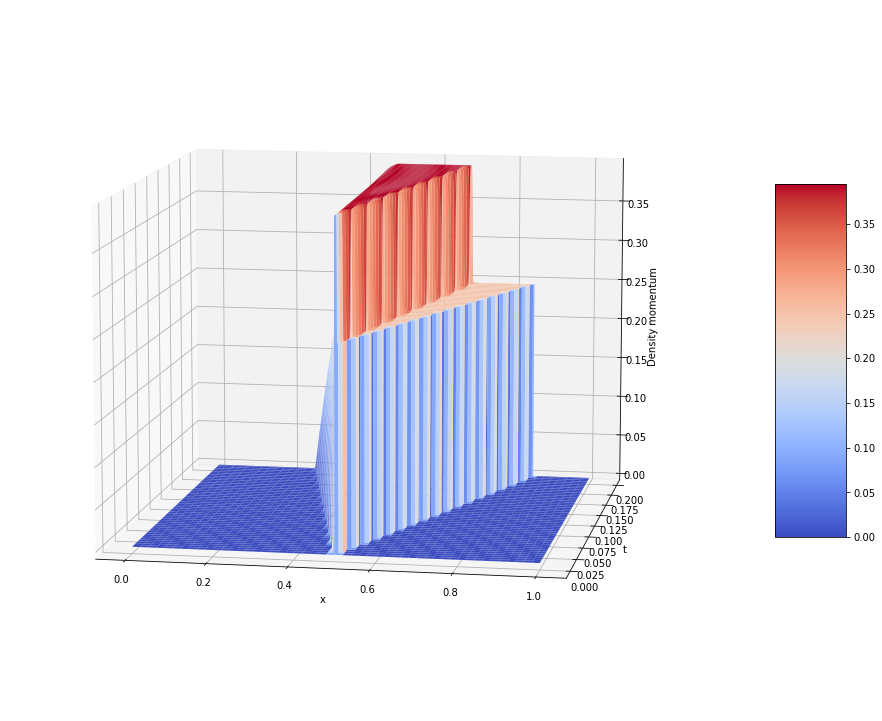

In [10]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.set_size_inches(22, 13)
surf = ax.plot_surface(X, T, j_evolved, cmap = cm.coolwarm, linewidth = 0, antialiased = True)
ax.view_init(elev = 10, azim = 280)
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("Density momentum")
fig.colorbar(surf, shrink = 0.5, aspect = 5)
plt.savefig("j_3D.png")
plt.show()

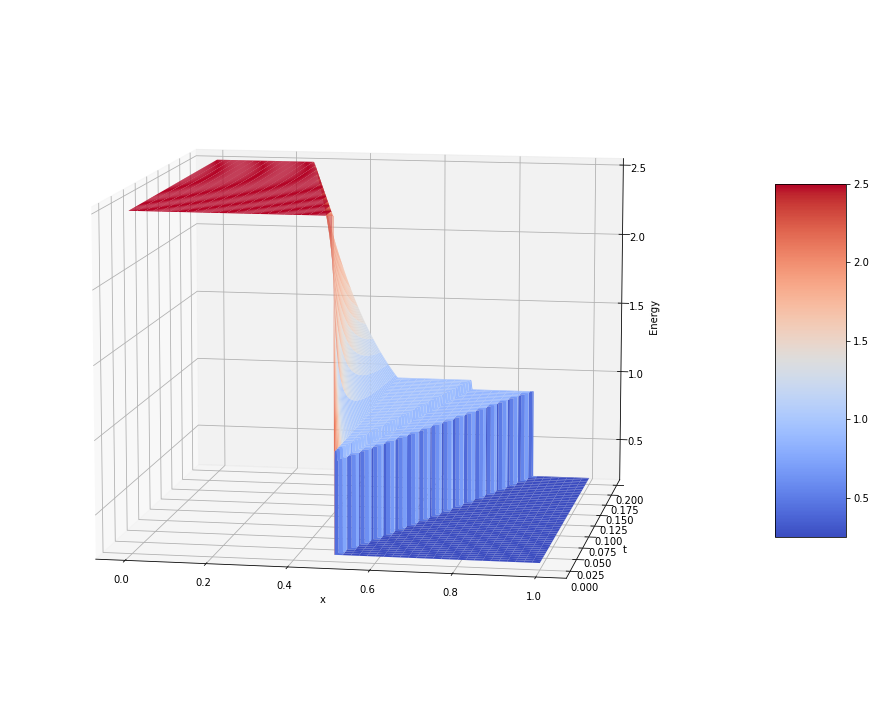

In [11]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.set_size_inches(22, 13)
surf = ax.plot_surface(X, T, e_evolved, cmap = cm.coolwarm, linewidth = 0, antialiased = True)
ax.view_init(elev = 10, azim = 280)
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("Energy")
fig.colorbar(surf, shrink = 0.5, aspect = 5)
plt.savefig("e_3D.png")
plt.show()

In [12]:
# Save data
import h5py

hf = h5py.File("Pyclaw_Classical_Euler_1D_Sod_Tube.h5", "w")
hf.create_dataset("times", data = times)
hf.create_dataset("x", data = x)
hf.create_dataset("rho_evolved", data = rho_evolved)
hf.create_dataset("j_evolved", data = j_evolved)
hf.create_dataset("e_evolved", data = e_evolved)
hf.close()